# SI618 Project 2

In [2]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
covid = pd.read_csv("./data/covid.csv") # newly updated dataset on date 2021-11-05
covid_ts = pd.read_csv("./data/covid_t.csv") # time series dataset

## Question1: Country conditions & COVID

How the condition of a country (indicated by indicators like GDP) make influence on the spread of COVID?

### Q1-1: gdp_per_capita v.s. total_cases_per_million

In [4]:
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency

Text(0.5, 1.0, 'Scatter plot between total COVID cases and GDP')

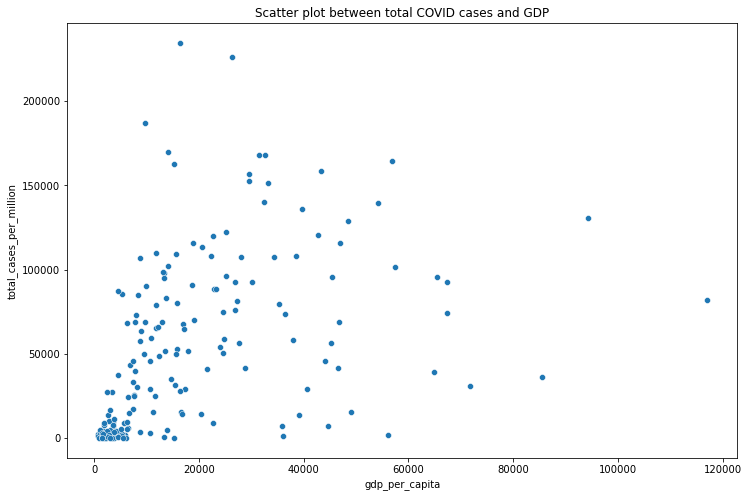

In [5]:
# overall view
df1 = covid[["iso_code", "gdp_per_capita", "total_cases_per_million"]].dropna()
plt.figure(figsize=(12,8))
sns.scatterplot(data=df1, x="gdp_per_capita", y="total_cases_per_million") \
    .set_title("Scatter plot between total COVID cases and GDP")

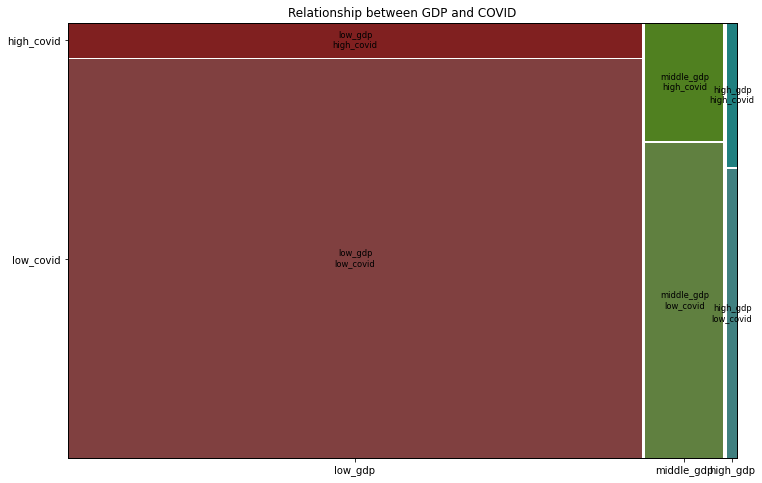

In [6]:
df1["gdp_level"] = pd.cut(df1["gdp_per_capita"], bins=3, 
                          labels=["low_gdp", "middle_gdp", "high_gdp"])
df1["covid_level"] = pd.cut(df1["total_cases_per_million"], bins=2, 
                            labels=["low_covid", "high_covid"])
# plot the mosaic plot
t = mosaic(df1, 
           ["gdp_level", "covid_level"], 
           title='Relationship between GDP and COVID')
t[0].set_size_inches(12,8)

In [7]:
# chi-square test (assume alpha = 0.05)
ct = pd.crosstab(df1["gdp_level"], df1["covid_level"])
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ",dof)
print("Expected:")
pd.DataFrame(ex)

chi2 =  9.149203444961929
p-val =  0.010310404762794585
degree of freedom =  2
Expected:


,0,1
0,144.673797,17.326203
1,19.647059,2.352941
2,2.679144,0.320856


### Q1-2: OLS for indicators v.s. total_cases_per_million

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
df1["reproduction_rate"] = covid["reproduction_rate"]
df1["handwashing_facilities"] = covid["handwashing_facilities"]
df1["hospital_beds_per_thousand"] = covid["hospital_beds_per_thousand"]

model1 = smf.ols('total_cases_per_million ~ gdp_per_capita + handwashing_facilities + hospital_beds_per_thousand', data=df1).fit()
model2 = smf.ols('reproduction_rate ~ gdp_per_capita + handwashing_facilities + hospital_beds_per_thousand', data=df1).fit()
model1.summary(), model2.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                OLS Regression Results                              
 Dep. Variable:     total_cases_per_million   R-squared:                       0.477
 Model:                                 OLS   Adj. R-squared:                  0.456
 Method:                      Least Squares   F-statistic:                     22.22
 Date:                     Tue, 07 Dec 2021   Prob (F-statistic):           2.51e-10
 Time:                             22:05:26   Log-Likelihood:                -887.59
 No. Observations:                       77   AIC:                             1783.
 Df Residuals:                           73   BIC:                             1793.
 Df Model:                                3                                         
 Covariance Type:                 nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
 ---

## Question 2: COVID & Human reactions

How COVID affect human behavior in the country level？

### Q2-1: reproduction_rate v.s. stringency_index

<AxesSubplot:xlabel='reproduction_rate', ylabel='stringency_index'>

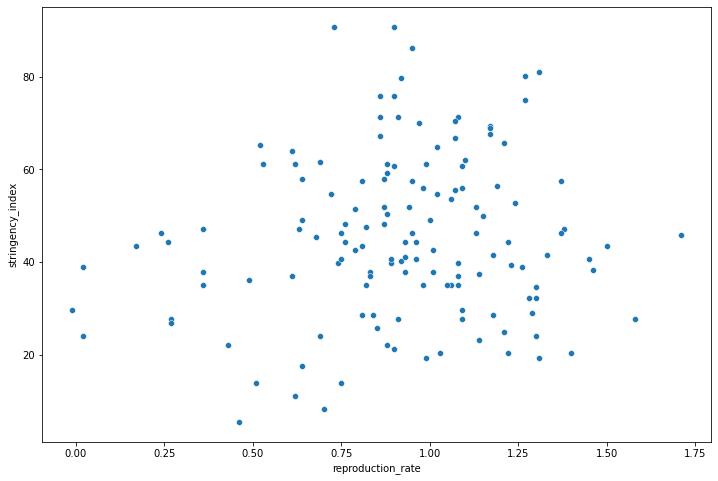

In [9]:
# overall view
df2 = covid[["iso_code", "reproduction_rate", "stringency_index"]].dropna()
plt.figure(figsize=(12,8))
sns.scatterplot(data=df2, x="reproduction_rate", y="stringency_index")

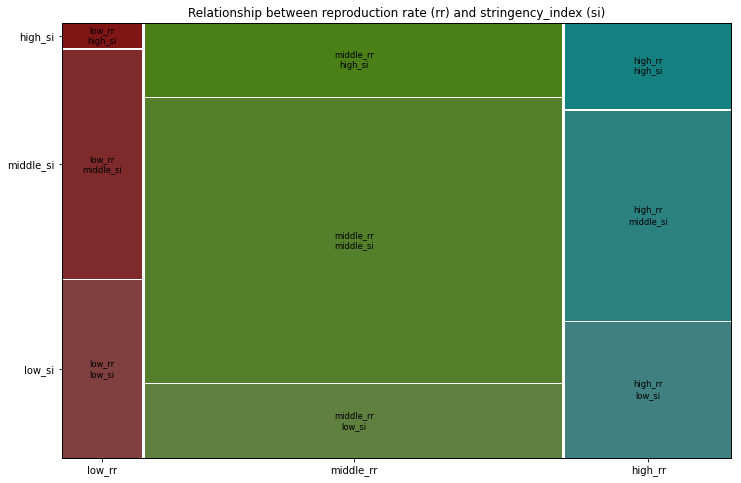

In [10]:
df2["rr_level"] = pd.cut(df2["reproduction_rate"], bins=3, 
                          labels=["low_rr", "middle_rr", "high_rr"])
df2["si_level"] = pd.cut(df2["stringency_index"], bins=3, 
                            labels=["low_si", "middle_si", "high_si"])
# plot the mosaic plot
t = mosaic(df2, 
           ["rr_level", "si_level"], 
           title='Relationship between reproduction rate (rr) and stringency_index (si)')
t[0].set_size_inches(12,8)

In [11]:
ct = pd.crosstab(df2["rr_level"], df2["si_level"])
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ",dof)
print("Expected:")
pd.DataFrame(ex)

chi2 =  7.6001770453060855
p-val =  0.10737217993872845
degree of freedom =  4
Expected:


,0,1,2
0,4.007143,10.2,2.792857
1,20.742857,52.8,14.457143
2,8.250000,21.0,5.750000


### Q2-2: reproduction_rate v.s. total_vaccinations_per_hundred (or people_vaccinated_per_hundred)

<AxesSubplot:xlabel='reproduction_rate', ylabel='total_vaccinations_per_hundred'>

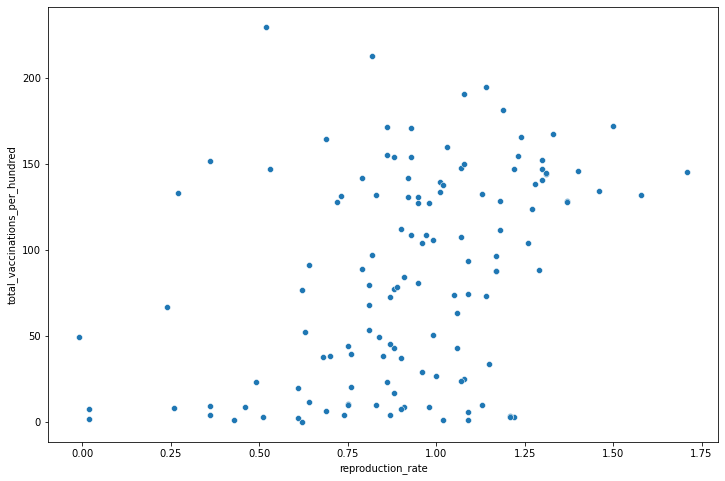

In [12]:
df2["total_vaccinations_per_hundred"] = covid["total_vaccinations_per_hundred"]
plt.figure(figsize=(12,8))
sns.scatterplot(data=df2, x="reproduction_rate", y="total_vaccinations_per_hundred")

## Question 3: Human reaction & COVID over time

How human behaviors make influence on the COVID over time?

### Q3-1: new_cases_per_million & new_vaccinations_smoothed_per_million v.s. time

In [76]:
from datetime import datetime

In [81]:
def get_sample(data = covid_ts):
    random.seed(10)
    sample_countries = random.sample(set(data["location"]), 10)
    sample_data = data[[(c in sample_countries) for c in data["location"]]]
    return sample_data

def get_sample_from_group(data = covid_ts):
    random.seed(10)
    sample_countries = random.sample(set(data.index.get_level_values('location')), 10)
    sample_list = []
    for c in sample_countries:
        sample_list.append(data.iloc[data.index.get_level_values('location') == c])
    return sample_list

In [82]:
# convert the date to year, month and day
df3 = covid_ts[["iso_code", "location", "date", "total_cases_per_million", "new_cases_per_million", "total_vaccinations_per_hundred", "new_vaccinations_smoothed_per_million"]].dropna()
df3["datestamp"] = [datetime.strptime(d, '%Y-%m-%d') for d in df3['date']]
df3["year"] = df3['datestamp'].dt.year
df3["month"] = df3['datestamp'].dt.month
df3["day"] = df3['datestamp'].dt.day
df3

,iso_code,location,date,total_cases_per_million,new_cases_per_million,total_vaccinations_per_hundred,new_vaccinations_smoothed_per_million,datestamp,year,month,day
370,AFG,Afghanistan,2021-02-28,1398.604,0.176,0.02,34.0,2021-02-28,2021,2,28
386,AFG,Afghanistan,2021-03-16,1405.658,0.251,0.14,72.0,2021-03-16,2021,3,16
408,AFG,Afghanistan,2021-04-07,1427.699,2.360,0.30,75.0,2021-04-07,2021,4,7
423,AFG,Afghanistan,2021-04-22,1463.823,2.460,0.60,201.0,2021-04-22,2021,4,22
442,AFG,Afghanistan,2021-05-11,1566.520,8.535,1.27,349.0,2021-05-11,2021,5,11
...,...,...,...,...,...,...,...,...,...,...,...
125092,ZWE,Zimbabwe,2021-10-16,8768.321,3.180,37.69,1095.0,2021-10-16,2021,10,16
125093,ZWE,Zimbabwe,2021-10-17,8770.640,2.319,37.78,1137.0,2021-10-17,2021,10,17
125094,ZWE,Zimbabwe,2021-10-18,8770.640,0.000,38.05,1403.0,2021-10-18,2021,10,18
125095,ZWE,Zimbabwe,2021-10-19,8773.092,2.452,38.14,1366.0,2021-10-19,2021,10,19


In [86]:
# sample 10 country from all
df3_group = df3.groupby(["location", "year", "month"]).mean()
df3_sample_list = get_sample_from_group(df3_group)
df3_sample = pd.concat([df.reset_index() for df in df3_sample_list]).reset_index().drop(columns=["day"])
df3_sample["new_cases_per_million_time_10"] = df3_sample["new_cases_per_million"] * 10
df3_sample

,index,location,year,month,total_cases_per_million,new_cases_per_million,total_vaccinations_per_hundred,new_vaccinations_smoothed_per_million,new_cases_per_million_time_10
0,0,Philippines,2021,3,5644.232313,41.680062,0.193750,155.875000,416.800625
1,1,Philippines,2021,4,8486.297421,81.390842,1.359474,361.684211,813.908421
2,2,Philippines,2021,5,10244.369636,54.348455,2.946364,920.409091,543.484545
3,3,Philippines,2021,6,11891.616870,55.572957,6.707391,1439.217391,555.729565
4,4,Philippines,2021,7,13461.223611,50.238944,12.935556,2354.722222,502.389444
...,...,...,...,...,...,...,...,...,...
79,6,Chile,2021,6,77238.261067,297.648633,109.454667,7450.900000,2976.486333
80,7,Chile,2021,7,82923.962839,100.521645,128.860323,5124.516129,1005.216452
81,8,Chile,2021,8,84786.750419,38.456387,142.356129,4929.064516,384.563871
82,9,Chile,2021,9,85674.976633,27.046833,159.507000,5521.733333,270.468333


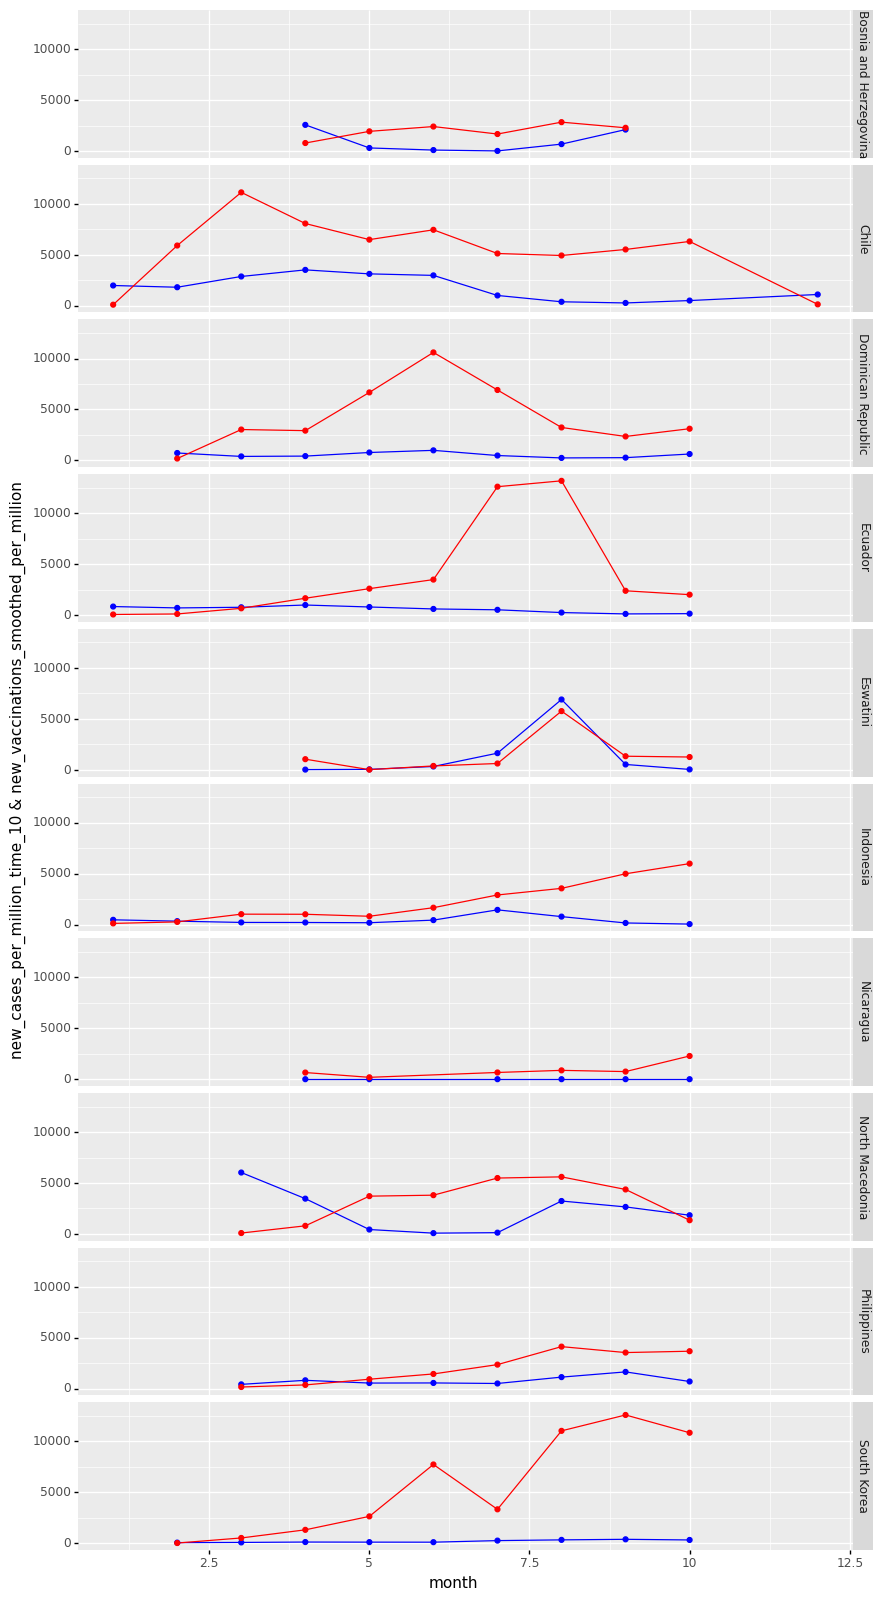

<ggplot: (146184392834)>

In [88]:
from plotnine import *
avg = stat_summary(aes(group = 1), fun_y = np.mean, geom = "line", colour = "red", size = 1, na_rm = True) 
line = geom_smooth(aes(group = 1), method='lm')
ggplot(df3_sample, aes(x='month')) + \
    geom_line(aes(y='new_cases_per_million_time_10'), color='blue') + \
    geom_line(aes(y='new_vaccinations_smoothed_per_million'), color='red') + \
    geom_point(aes(y='new_cases_per_million_time_10'), color='blue') + \
    geom_point(aes(y='new_vaccinations_smoothed_per_million'), color='red') + \
    facet_grid('location ~ .') + \
    labs(x='month', y='new_cases_per_million_time_10 & new_vaccinations_smoothed_per_million') + \
    theme(figure_size=(10, 20))